# Short Calibrator Correlation Function

In [2]:
import numpy as np
import statistics as stat
import scipy
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import PrizmCalibration as cl # this module is missing dependencies
from gsm_data import GSMData, get_desired_frequencies
# from data_prep import DataPrep

# For reloading the module (useful for debugging)
import data
import data_prep
try:
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep
except:
    from importlib import reload
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep

from helper_functions import *
import data_utils as du

import copy

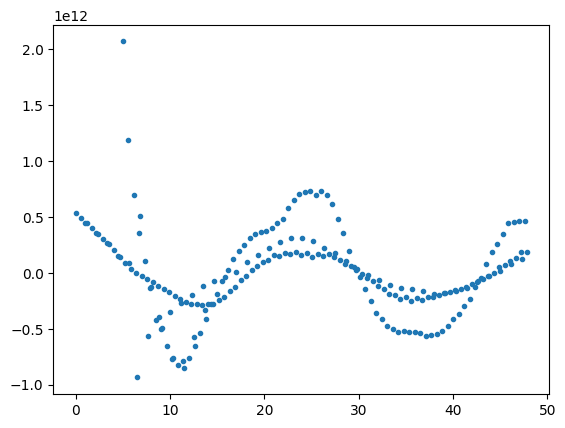

In [3]:
# Jon's code
import test_short_interp

# This is the weird correlation function. It should not look like there are 3 different lines like that.

In [3]:
# Flag the 'bad' spectra
# For a first pass I have to fetch the mask from DataPrep
year = '2021'
instrument = '100MHz'
channel = 'NS'

dataprep = DataPrep(instrument, channel, year)
save_mask = copy.deepcopy(dataprep.calib_mask_dict['short']) # save the mask

Returning default mask
Returning default mask


In [4]:
from test_short_interp import make_acf

In [5]:
datadir = '../test_data/2021/100MHz/NS/'

dat=np.load(datadir+'shortdata_meas_2021_100MHz_NS.npy')[save_mask]
lst=np.load(datadir+'shortlst_2021_100MHz_NS.npy')[save_mask]
t=np.load(datadir+'shortsystime_2021_100MHz_NS.npy')[save_mask]

dat_nomask = np.load(datadir+'shortdata_meas_2021_100MHz_NS.npy')
lst_nomask = np.load(datadir+'shortlst_2021_100MHz_NS.npy')
t_nomask = np.load(datadir+'shortsystime_2021_100MHz_NS.npy')

In [6]:
freqarr, freqstep = np.linspace(0,250,4096,retstep=True) # Based on number of frequency channels of the antenna
minfreq = 30
maxfreq = 200
minfreqarg = int(minfreq/freqstep)
maxfreqarg = int(maxfreq/freqstep)

## Checking different frequency channels

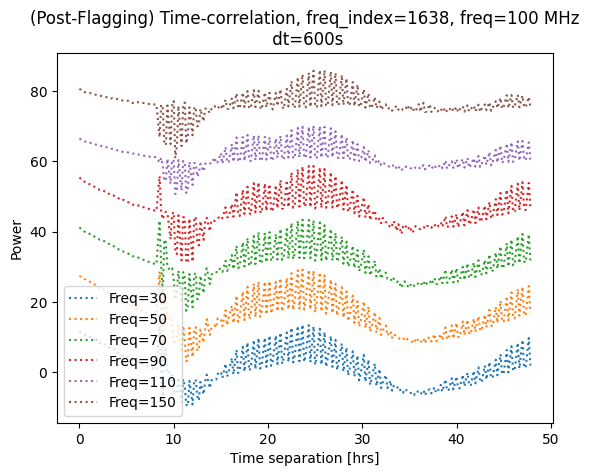

In [110]:
# freq channels to investigate:
check_freqs = np.array([30,50,70,90,110,150]) # MHz
check_freqs_inds = (check_freqs/freqstep).astype(int)

# -------------------------
tmax=1.6374e9
tmin=1.6365e9

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]
ll=lst[mask]

mask_nm=(t_nomask>tmin)&(t_nomask<tmax)
tt_nomask=t_nomask[mask_nm]
dd_nomask=dat_nomask[mask_nm,:]
ll_nomask=lst_nomask[mask_nm]

dt=600

for i,freqi in enumerate(check_freqs_inds):
    tot,wt=make_acf(dd[:,freqi]-dd[:,freqi].mean(),tt,dt=dt,tmax=2*86400)
    tvec=np.arange(len(tot))*dt
    mm=wt>30
    plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm])/np.mean(tot[mm]/wt[mm]) + i*15,':',label='Freq='+str(check_freqs[i]))

plt.title('(Post-Flagging) Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.legend()
plt.show()

## 100 MHz Channel

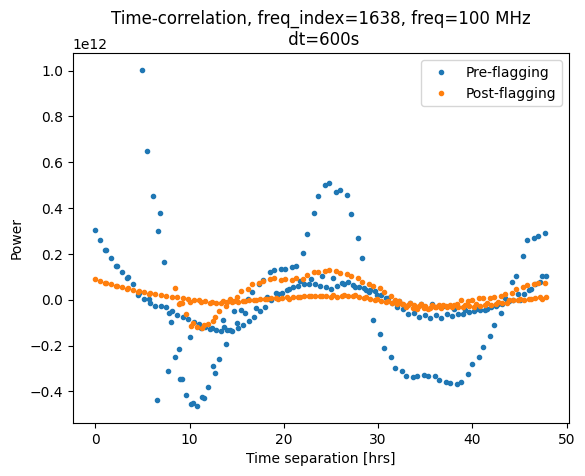

In [65]:
tmax=1.6374e9
tmin=1.6365e9

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]
ll=lst[mask]

mask_nm=(t_nomask>tmin)&(t_nomask<tmax)
tt_nomask=t_nomask[mask_nm]
dd_nomask=dat_nomask[mask_nm,:]
ll_nomask=lst_nomask[mask_nm]

freq = 100 # MHz
freq_index = int(freq/freqstep)

dt=600
tot,wt=make_acf(dd_nomask[:,freq_index]-dd_nomask[:,freq_index].mean(),tt_nomask,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
mm=wt>30
plt.clf()
plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='Pre-flagging')

tot,wt=make_acf(dd[:,freq_index]-dd[:,freq_index].mean(),tt,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
mm=wt>30

plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='Post-flagging')

plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.legend()
plt.show()

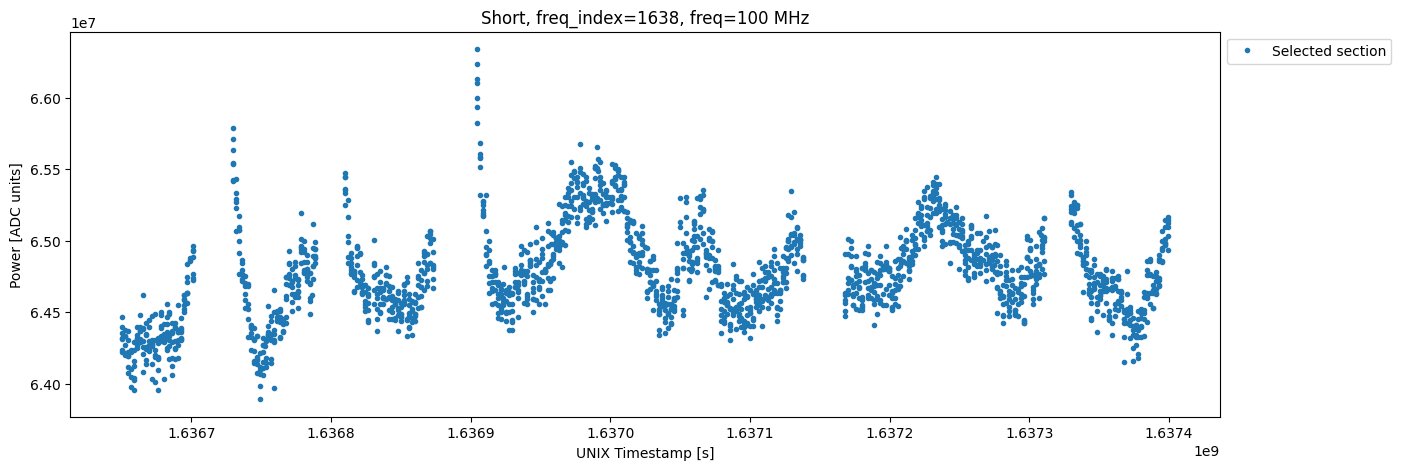

In [86]:
# vs UNIX timestamp

freq = 100 # MHz
freq_index = int(freq/freqstep)

plt.figure(figsize=(20,5))
# plt.plot(t,dat[:,freq_index],'.',label='All times')
plt.plot(tt,dd[:,freq_index],'.',label='Selected section')
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.show()

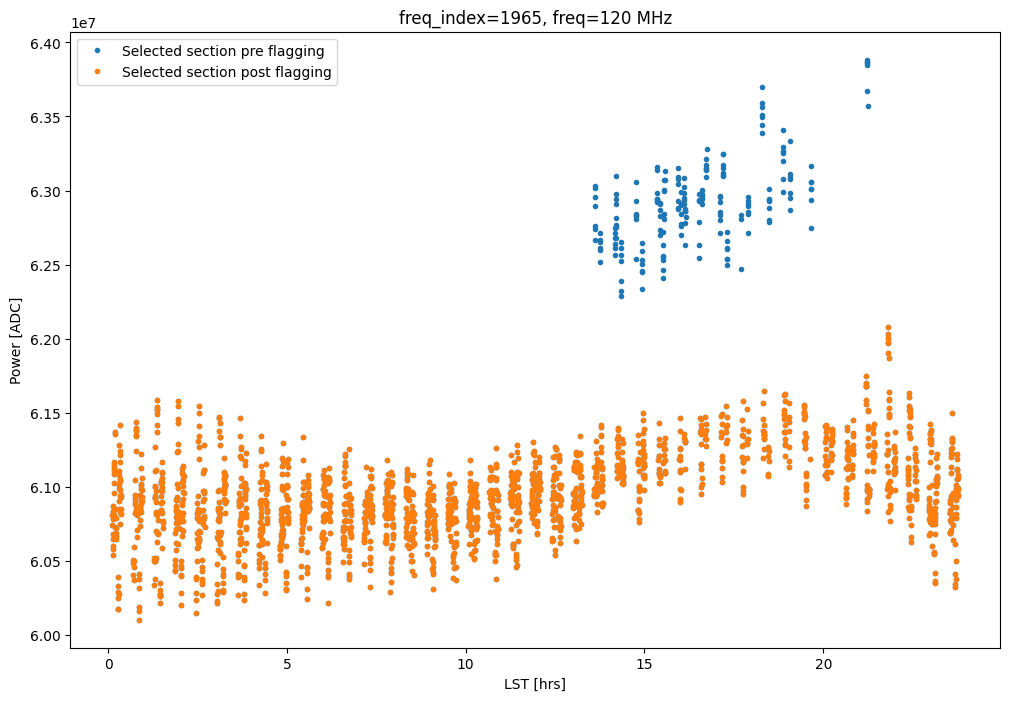

In [9]:
# vs LST

plt.figure(figsize=(12,8))
plt.plot(ll_nomask,dd_nomask[:,freq_index],'.',label='Selected section pre flagging')
plt.plot(ll,dd[:,freq_index],'.',label='Selected section post flagging')
plt.title('freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend()
plt.xlabel('LST [hrs]')
plt.ylabel('Power [ADC]')
plt.show()

# Bunch of these weird guys. Some spectra are behaving differently at low LST. Make waterfall plot to see if I can identify them?

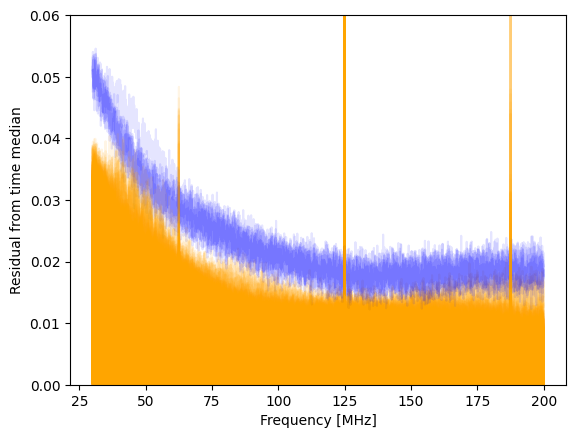

In [10]:
# Plotting remaining spectra

time_median = np.median(dd[:],axis=0)
res_data = np.abs((dd[:] - time_median)/time_median)

outlier_i = []

for i,ll_i in enumerate(ll):
    if res_data[i,minfreqarg] > 0.043:
        plt.plot(freqarr[minfreqarg:maxfreqarg],res_data[i,minfreqarg:maxfreqarg],color='blue',alpha=0.1)
        outlier_i.append(i)
        
#     if i >= 550 and i <= 600:
#         plt.plot(freqarr[minfreqarg:maxfreqarg],res_data[i,minfreqarg:maxfreqarg],color='blue',alpha=0.1)
    else:
        plt.plot(freqarr[minfreqarg:maxfreqarg],res_data[i,minfreqarg:maxfreqarg],color='orange',alpha=0.1)

plt.ylim(bottom=0,top=0.06)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Residual from time median')
plt.show()

In [11]:
outlier_i

[568, 569, 570, 571, 572, 573, 574]

[False False False False False False False]


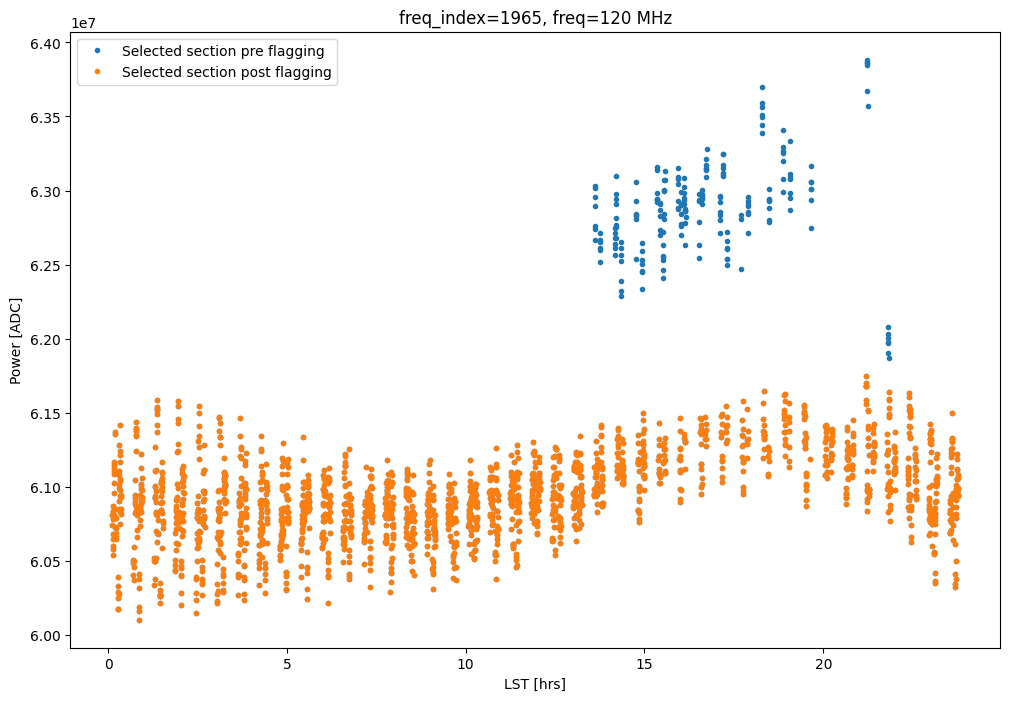

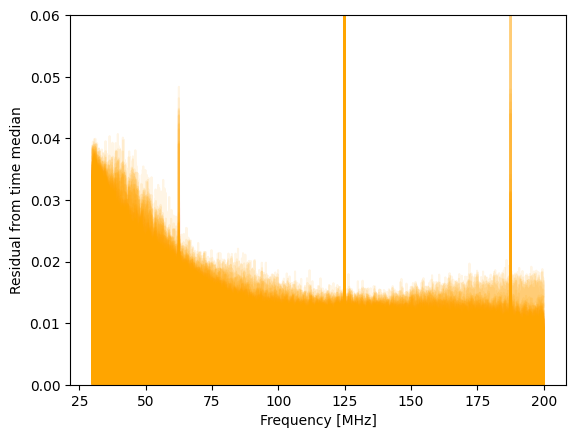

In [12]:
# Make new mask
trial_mask = np.ones(len(ll)) == True
trial_mask[outlier_i] = False
print(trial_mask[outlier_i])

trial_ll = ll[trial_mask]
trial_dd = dd[trial_mask]
trial_tt = tt[trial_mask]

plt.figure(figsize=(12,8))
plt.plot(ll_nomask,dd_nomask[:,freq_index],'.',label='Selected section pre flagging')
plt.plot(trial_ll,trial_dd[:,freq_index],'.',label='Selected section post flagging')
plt.title('freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend()
plt.xlabel('LST [hrs]')
plt.ylabel('Power [ADC]')
plt.show()

# time_median = np.median(trial_dd[:],axis=0)
# res_data = np.abs((trial_dd[:] - time_median)/time_median)

# res_data = res_data[trial_mask]

for i,ll_i in enumerate(trial_ll):
    plt.plot(freqarr[minfreqarg:maxfreqarg],res_data[trial_mask][i,minfreqarg:maxfreqarg],color='orange',alpha=0.1)

plt.ylim(bottom=0,top=0.06)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Residual from time median')
plt.show()

## Checking patterns in the autocorrelation

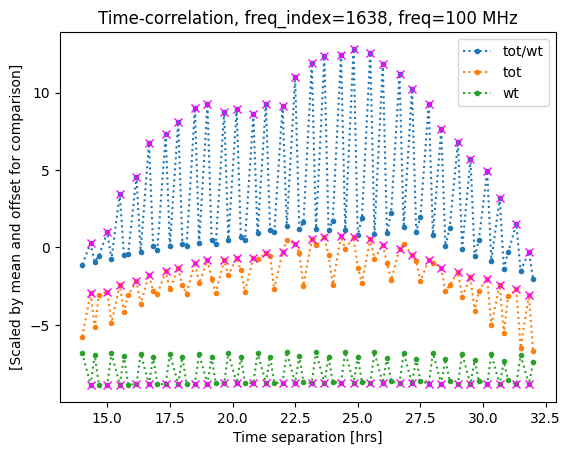

In [54]:
tmax=1.6374e9
tmin=1.6365e9

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]
ll=lst[mask]

mask_nm=(t_nomask>tmin)&(t_nomask<tmax)
tt_nomask=t_nomask[mask_nm]
dd_nomask=dat_nomask[mask_nm,:]
ll_nomask=lst_nomask[mask_nm]

freq = 100 # MHz
freq_index = int(freq/freqstep)
# freq_index = 1000

dt=600
# tot,wt=make_acf(dd_nomask[:,freq_index]-dd_nomask[:,freq_index].mean(),tt_nomask,dt=dt,tmax=2*86400)
# tvec=np.arange(len(tot))*dt
# mm=wt>30
plt.clf()
# plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='Pre-flagging')

# tot,wt=make_acf(dd[:,freq_index]-dd[:,freq_index].mean(),tt,dt=dt,tmax=2*86400)
# tvec=np.arange(len(tot))*dt
# mm=wt>30
# plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='Post-flagging')
upper_indices = np.array([1,4,6,9,11,14,16,19,21,24,26,29,31,34,36,39,41,44,46,49,51,54,56,59,61,64,66,69,71,74,76])

tot,wt=make_acf(trial_dd[:,freq_index]-trial_dd[:,freq_index].mean(),trial_tt,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
mm=wt>30
plt.plot(tvec[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)]/3600,(tot[mm]/wt[mm])[(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)]/np.mean((tot[mm]/wt[mm])),':.',label='tot/wt')
plt.plot(tvec[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)][upper_indices]/3600,(tot[mm]/wt[mm])[(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)][upper_indices]/np.mean((tot[mm]/wt[mm])),marker='x',ls='none',color='magenta')

plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.ylabel('[Scaled by mean and offset for comparison]')
plt.xlabel('Time separation [hrs]')

plt.plot(tvec[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)]/3600,tot[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)]/np.mean(tot[mm]) - 3,':.',label='tot')
plt.plot(tvec[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)][upper_indices]/3600,tot[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)][upper_indices]/np.mean(tot[mm]) - 3,marker='x',ls='none',color='magenta')

plt.plot(tvec[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)]/3600,wt[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)]/np.mean(wt[mm]) - 9,':.',label='wt')
plt.plot(tvec[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)][upper_indices]/3600,wt[mm][(tvec[mm]/3600>=14)&(tvec[mm]/3600<=32)][upper_indices]/np.mean(wt[mm]) - 9,marker='x',ls='none',color='magenta')

# plt.yscale('log')
plt.legend()
plt.show()

## Checking if certain chunks of the time series are the problem

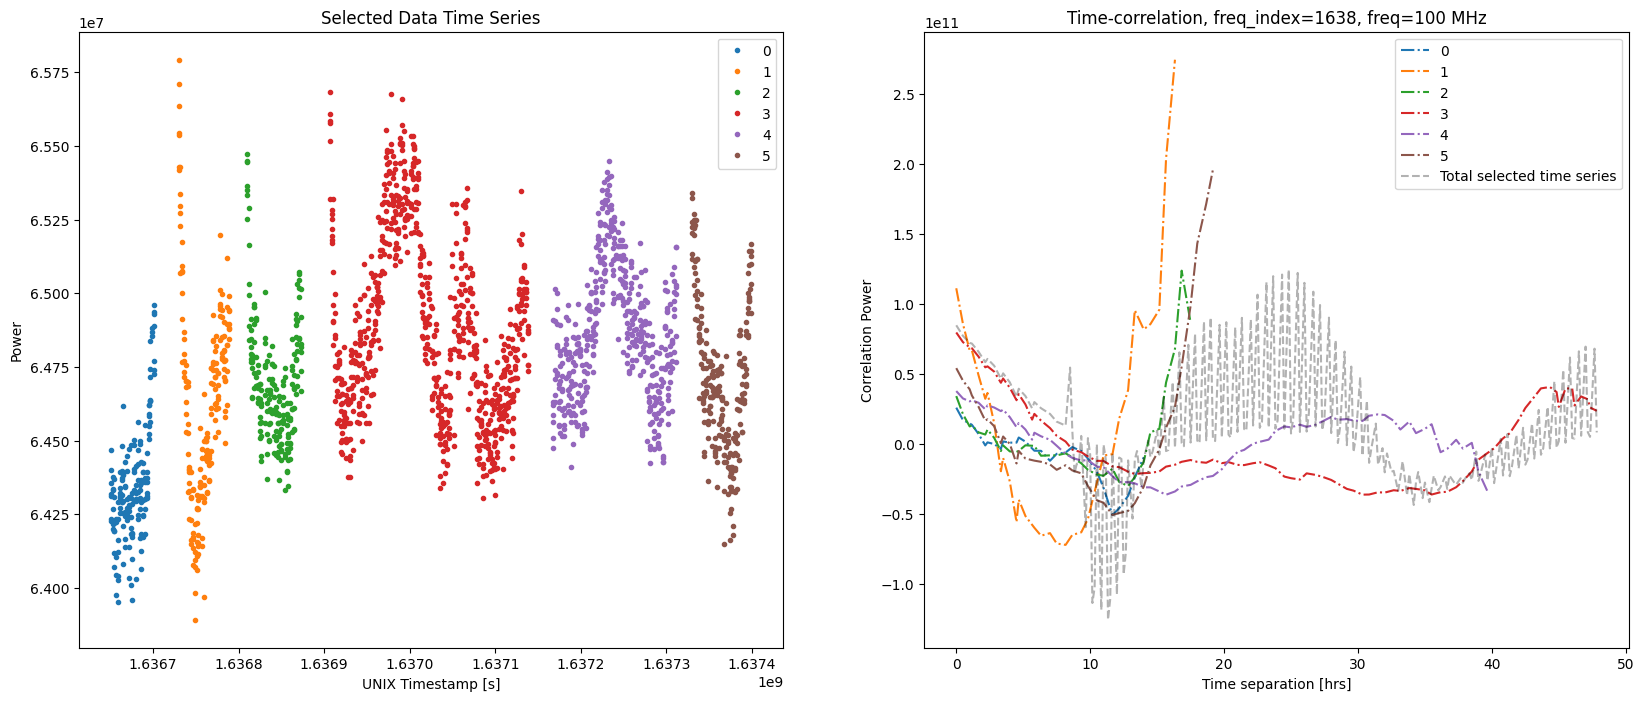

In [21]:
# Trying to take really just one continuous chunk of the selected portion
delims = np.array([1.63672,1.6368,1.6369,1.63715,1.63732])*1e9 # seconds
# markerline = np.array([':^',':s',':p',':P',':d',':*'])
markerline = np.array([':',':',':',':',':',':'])
markerline = np.array(['-.','-.','-.','-.','-.','-.'])

plt.figure(figsize=(20,8))

for i in range(len(delims)+1):
#     print(i)
    if i == 0:
#         print('first')
        single_chunk_mask = trial_tt<delims[i]
    elif i == len(delims):
#         print('last')
        single_chunk_mask = trial_tt>delims[i-1]
    else:
#         print('middle')
        single_chunk_mask = (trial_tt>delims[i-1])&(trial_tt<delims[i])
    
    tt_singlechunk=trial_tt[single_chunk_mask]
    dd_singlechunk=trial_dd[single_chunk_mask,:]
    ll_singlechunk=trial_ll[single_chunk_mask]
    
    plt.subplot(121)
    plt.plot(tt_singlechunk,dd_singlechunk[:,freq_index],'.',label=str(i))

    freq = 100 # MHz
    freq_index = int(freq/freqstep)
    # freq_index = 1000

    dt=600
    tot,wt=make_acf(dd_singlechunk[:,freq_index]-dd_singlechunk[:,freq_index].mean(),tt_singlechunk,dt=dt,tmax=2*86400)
    tvec=np.arange(len(tot))*dt
    mm=wt>30
    plt.subplot(122)
    plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),markerline[i],label=str(i)) # 'Post-flagging + Extra + Single Chunk'

plt.subplot(121)
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Power')
plt.title('Selected Data Time Series')
plt.legend()

plt.subplot(122)
tot,wt=make_acf(trial_dd[:,freq_index]-trial_dd[:,freq_index].mean(),trial_tt,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
mm=wt>30
plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'--',label='Total selected time series',alpha=0.3,color='k')

plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.ylabel('Correlation Power')
plt.xlabel('Time separation [hrs]')
plt.legend()
plt.show()

In [17]:
import matplotlib.gridspec as gridspec

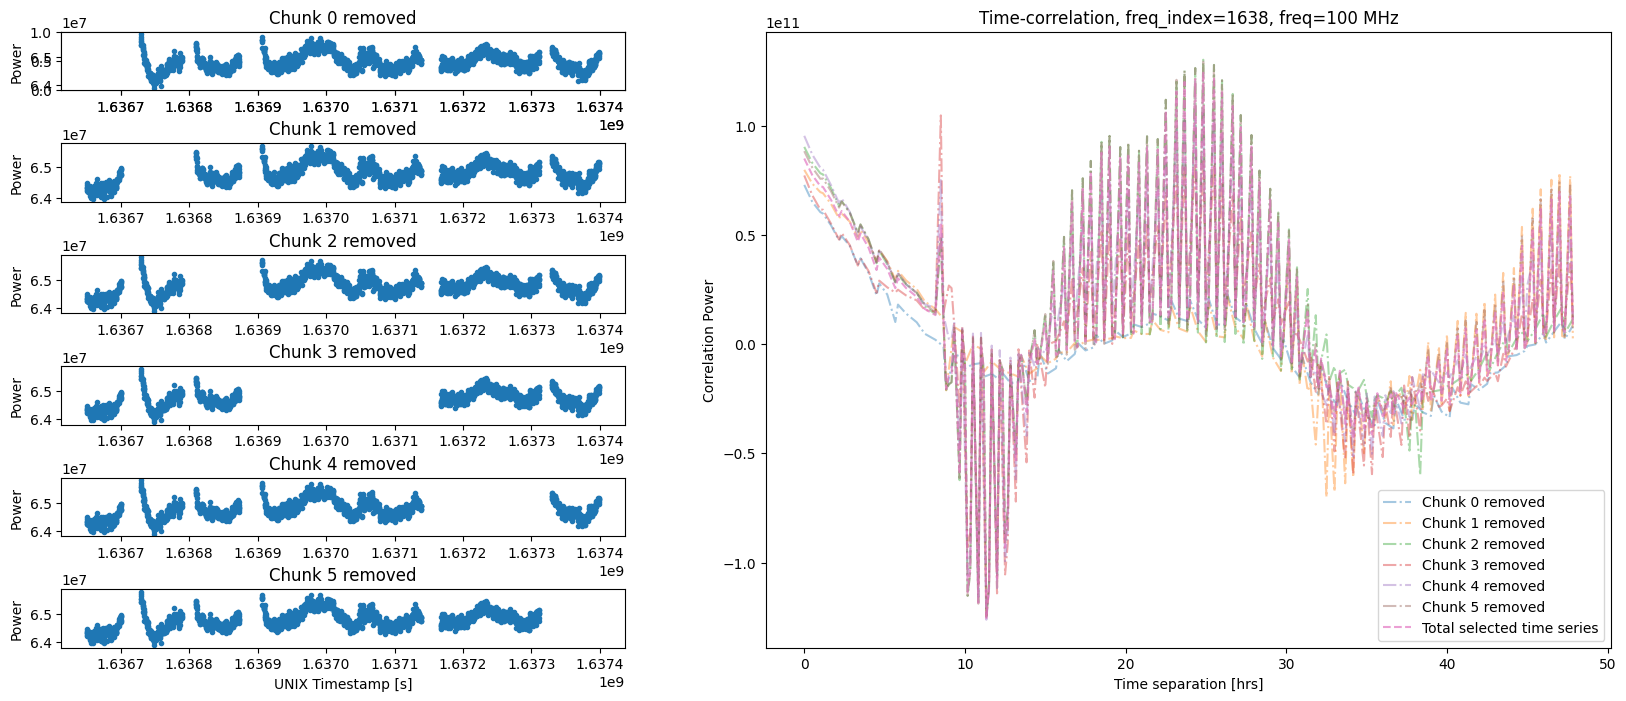

In [27]:
# Trying to take really just one continuous chunk of the selected portion
delims = np.array([1.63672,1.6368,1.6369,1.63715,1.63732])*1e9
# markerline = np.array([':^',':s',':p',':P',':d',':*'])
# markerline = np.array([':',':',':',':',':',':'])
markerline = np.array(['-.','-.','-.','-.','-.','-.'])
# zorders = np.array([6,5,4,3,2,1])


freq = 100 # MHz
freq_index = int(freq/freqstep)
# freq_index = 1000

dt=600


fig = plt.figure(figsize=(20,8))

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5])  # Adjust width_ratios as needed

# Sub GridSpec for left column
left_gs = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs[0])
ax = fig.add_subplot(left_gs[0, 0])
ax1 = fig.add_subplot(gs[1])

for i in range(len(delims)+1):
#     print(i)
    if i == 0:
        single_chunk_mask = trial_tt<delims[i]
    elif i == len(delims):
        single_chunk_mask = trial_tt>delims[i-1]
    else:
        single_chunk_mask = (trial_tt>delims[i-1])&(trial_tt<delims[i])
    
    single_chunk_mask = ~single_chunk_mask
    tt_singlechunk=trial_tt[single_chunk_mask]
    dd_singlechunk=trial_dd[single_chunk_mask,:]
    ll_singlechunk=trial_ll[single_chunk_mask]
    
    ax = fig.add_subplot(left_gs[i, 0],sharex=ax)
    ax.plot(tt_singlechunk,dd_singlechunk[:,freq_index],'.',label='Chunk '+str(i)+' removed')
    if i == len(delims):
        ax.set_xlabel('UNIX Timestamp [s]')
    ax.set_ylabel('Power')
    ax.set_title('Chunk '+str(i)+' removed')

    tot,wt=make_acf(dd_singlechunk[:,freq_index]-dd_singlechunk[:,freq_index].mean(),tt_singlechunk,dt=dt,tmax=2*86400)
    tvec=np.arange(len(tot))*dt
    mm=wt>30
    ax1.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),markerline[i],label='Chunk '+str(i)+' removed',alpha=0.4) # 'Post-flagging + Extra + Single Chunk'

tot,wt=make_acf(trial_dd[:,freq_index]-trial_dd[:,freq_index].mean(),trial_tt,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
mm=wt>30
ax1.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'--',label='Total selected time series',alpha=0.7)

ax1.set_title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
ax1.set_ylabel('Correlation Power')
ax1.set_xlabel('Time separation [hrs]')
ax1.legend()

plt.subplots_adjust(hspace=0.9, wspace=0.2)

plt.show()

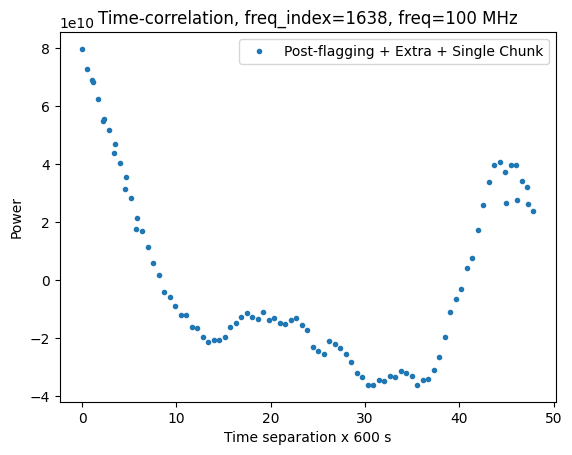

In [42]:
freq = 100 # MHz
freq_index = int(freq/freqstep)
# freq_index = 1000

dt=600
plt.clf()
tot,wt=make_acf(dd_singlechunk[:,freq_index]-dd_singlechunk[:,freq_index].mean(),tt_singlechunk,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
mm=wt>30
plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='Post-flagging + Extra + Single Chunk')

plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.ylabel('Power')
plt.xlabel('Time separation x '+str(dt)+' s')
plt.legend()
plt.show()

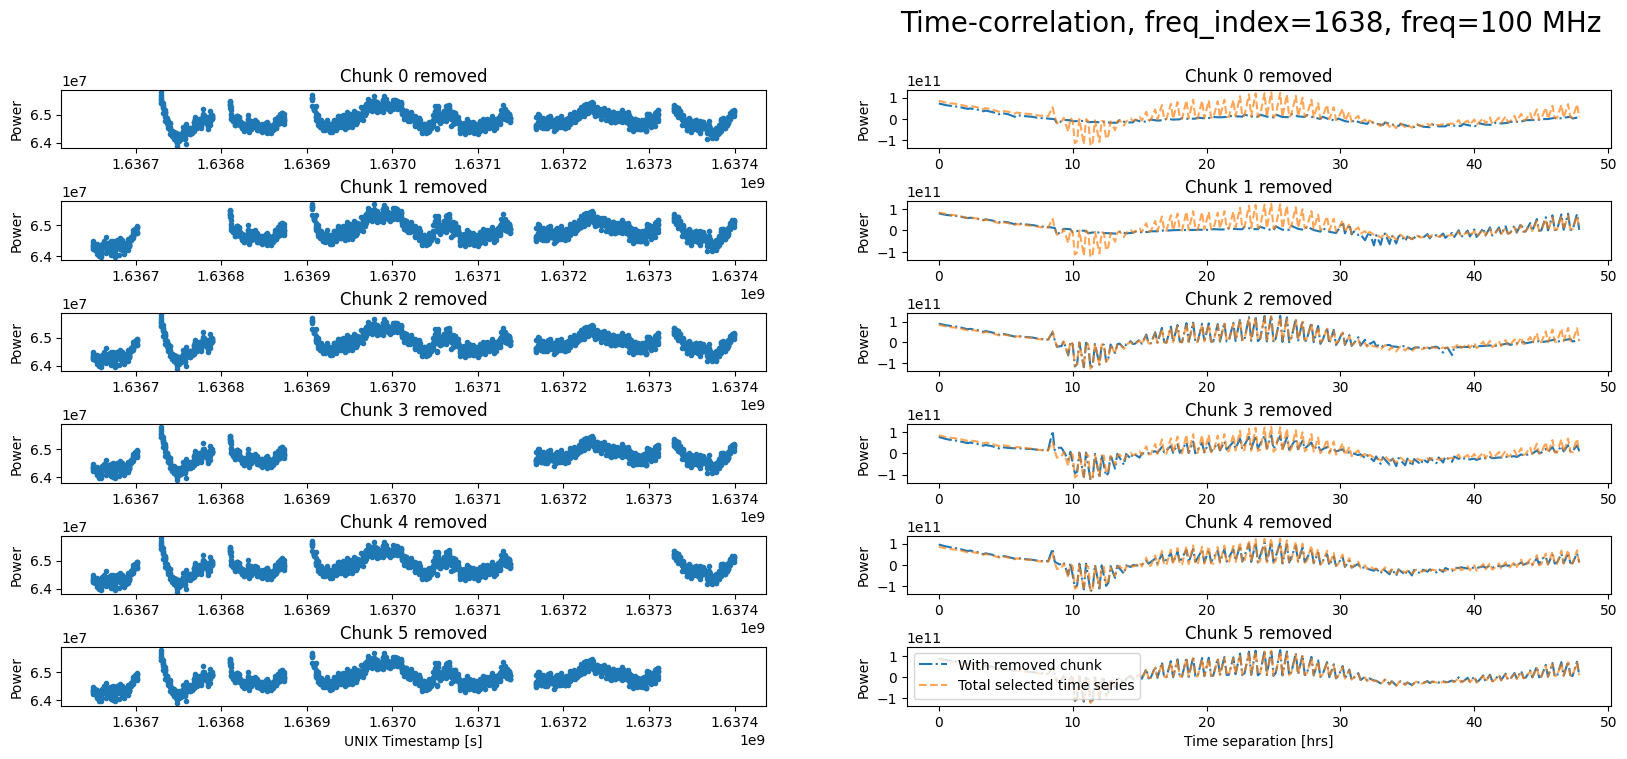

In [46]:
# Plotting the autocorrelations on 
delims = np.array([1.63672,1.6368,1.6369,1.63715,1.63732])*1e9
# markerline = np.array([':^',':s',':p',':P',':d',':*'])
# markerline = np.array([':',':',':',':',':',':'])
markerline = np.array(['-.','-.','-.','-.','-.','-.'])
# zorders = np.array([6,5,4,3,2,1])


freq = 100 # MHz
freq_index = int(freq/freqstep)
# freq_index = 1000

dt=600


fig = plt.figure(figsize=(20,8))

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # Adjust width_ratios as needed

# Sub GridSpec for left column
left_gs = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs[0])
# ax = fig.add_subplot(left_gs[0, 0])
right_gs = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs[1])
# ax1 = fig.add_subplot(right_gs[0, 0])

for i in range(len(delims)+1):
#     print(i)
    if i == 0:
        single_chunk_mask = trial_tt<delims[i]
    elif i == len(delims):
        single_chunk_mask = trial_tt>delims[i-1]
    else:
        single_chunk_mask = (trial_tt>delims[i-1])&(trial_tt<delims[i])
    
    single_chunk_mask = ~single_chunk_mask
    tt_singlechunk=trial_tt[single_chunk_mask]
    dd_singlechunk=trial_dd[single_chunk_mask,:]
    ll_singlechunk=trial_ll[single_chunk_mask]
    if i == 0:
        ax = fig.add_subplot(left_gs[i, 0])
    else:
        ax = fig.add_subplot(left_gs[i, 0],sharex=ax)
    ax.plot(tt_singlechunk,dd_singlechunk[:,freq_index],'.',label='Chunk '+str(i)+' removed')
    if i == len(delims):
        ax.set_xlabel('UNIX Timestamp [s]')
    ax.set_ylabel('Power')
    ax.set_title('Chunk '+str(i)+' removed')

    tot,wt=make_acf(dd_singlechunk[:,freq_index]-dd_singlechunk[:,freq_index].mean(),tt_singlechunk,dt=dt,tmax=2*86400)
    tvec=np.arange(len(tot))*dt
    mm=wt>30
    if i == 0:
        ax1 = fig.add_subplot(right_gs[i, 0])
    else:
        ax1 = fig.add_subplot(right_gs[i, 0],sharex=ax1)
    ax1.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),markerline[i],label='With removed chunk') # 'Post-flagging + Extra + Single Chunk'
    ax1.set_ylabel('Power')
    ax1.set_title('Chunk '+str(i)+' removed')
    
    tot,wt=make_acf(trial_dd[:,freq_index]-trial_dd[:,freq_index].mean(),trial_tt,dt=dt,tmax=2*86400)
    tvec=np.arange(len(tot))*dt
    mm=wt>30
    ax1.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'--',label='Total selected time series',alpha=0.7)


# tot,wt=make_acf(trial_dd[:,freq_index]-trial_dd[:,freq_index].mean(),trial_tt,dt=dt,tmax=2*86400)
# tvec=np.arange(len(tot))*dt
# mm=wt>30
# ax1.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'--',label='Total selected time series',alpha=0.7)

ax1.set_ylabel('Power')
ax1.set_xlabel('Time separation [hrs]')
ax1.legend()

plt.suptitle('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz',fontsize=20,x=0.72)
plt.subplots_adjust(hspace=0.9, wspace=0.2)

plt.show()

## Trying to artificially close the large time gaps to see if those are the problem

[28755.34769106 20995.51772881 31503.36404896 29668.85126281
 18896.32321072]


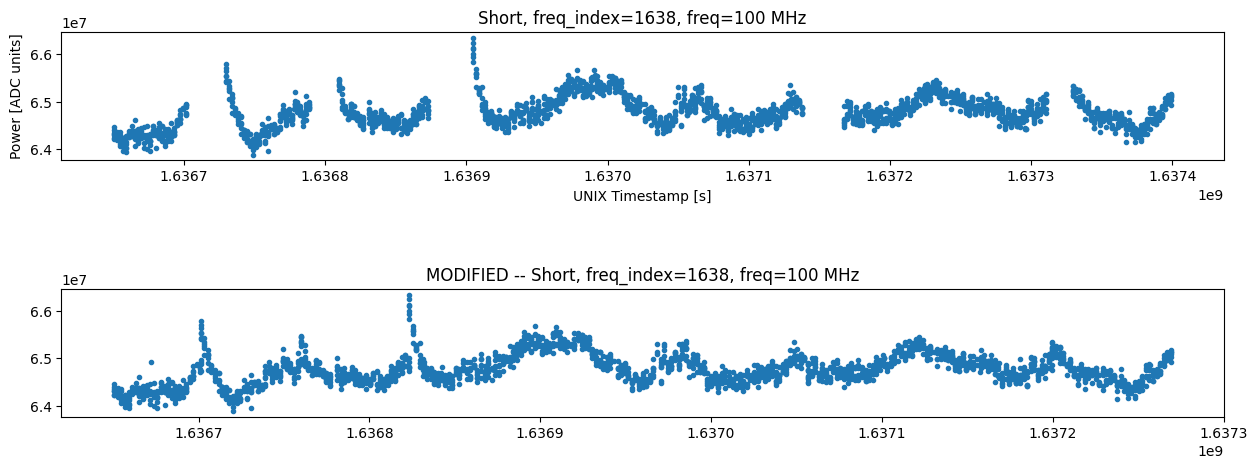

In [128]:
# vs UNIX timestamp

freq = 100 # MHz
freq_index = int(freq/freqstep)

# Find where the big timegaps are
tgaps = np.diff(tt)
n = 5 # there are 5 big timegaps
indices_of_largest = np.argsort(tgaps)[-n:]
sorted_indices = np.sort(indices_of_largest) # Sort indices to preserve the original order
n_largest_values = tgaps[sorted_indices]
print(n_largest_values)

tt_mod = copy.deepcopy(tt)

for i,tg in enumerate(n_largest_values):
    tt_mod[sorted_indices[i]:] = tt_mod[sorted_indices[i]:] - tg

plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(tt,dd[:,freq_index],'.',label='Selected section')
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
# plt.legend(loc='upper left',bbox_to_anchor=(1, 1))

plt.subplot(212)
plt.plot(tt_mod,dd[:,freq_index],'.',label='modified')
plt.title('MODIFIED -- Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
# plt.legend(loc='upper left',bbox_to_anchor=(1, 1))

plt.subplots_adjust(hspace=1)
plt.show()

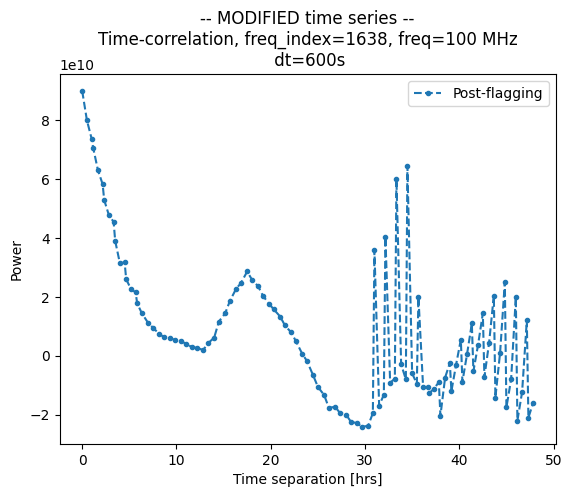

In [133]:
# Now that we have a modified array, let's try to take the correlation
freq = 100 # MHz
freq_index = int(freq/freqstep)

dt=600
plt.clf()

tot,wt=make_acf(dd[:,freq_index]-dd[:,freq_index].mean(),tt_mod,dt=dt,tmax=2*86400) # note tt_mod
tvec=np.arange(len(tot))*dt
mm=wt>30

plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'--.',label='Post-flagging')

plt.title('-- MODIFIED time series --\nTime-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.legend()
plt.show()

## Trying a different data set

(Maybe this is a problem with the 100MHz 2021 NS data)

In [144]:
# Flag the 'bad' spectra
# For a first pass I have to fetch the mask from DataPrep
year = '2018'
instrument = '70MHz'
channel = 'EW'

dataprep = DataPrep(instrument, channel, year)
save_mask_EW = copy.deepcopy(dataprep.calib_mask_dict['short']) # save the mask

Returning default mask
Returning default mask


In [145]:
datadir = '../test_data/2018/70MHz/EW/'

dat=np.load(datadir+'shortdata_meas_2018_70MHz_EW.npy')[save_mask_EW]
lst=np.load(datadir+'shortlst_2018_70MHz_EW.npy')[save_mask_EW]
t=np.load(datadir+'shortsystime_2018_70MHz_EW.npy')[save_mask_EW]

dat_nomask = np.load(datadir+'shortdata_meas_2018_70MHz_EW.npy')
lst_nomask = np.load(datadir+'shortlst_2018_70MHz_EW.npy')
t_nomask = np.load(datadir+'shortsystime_2018_70MHz_EW.npy')

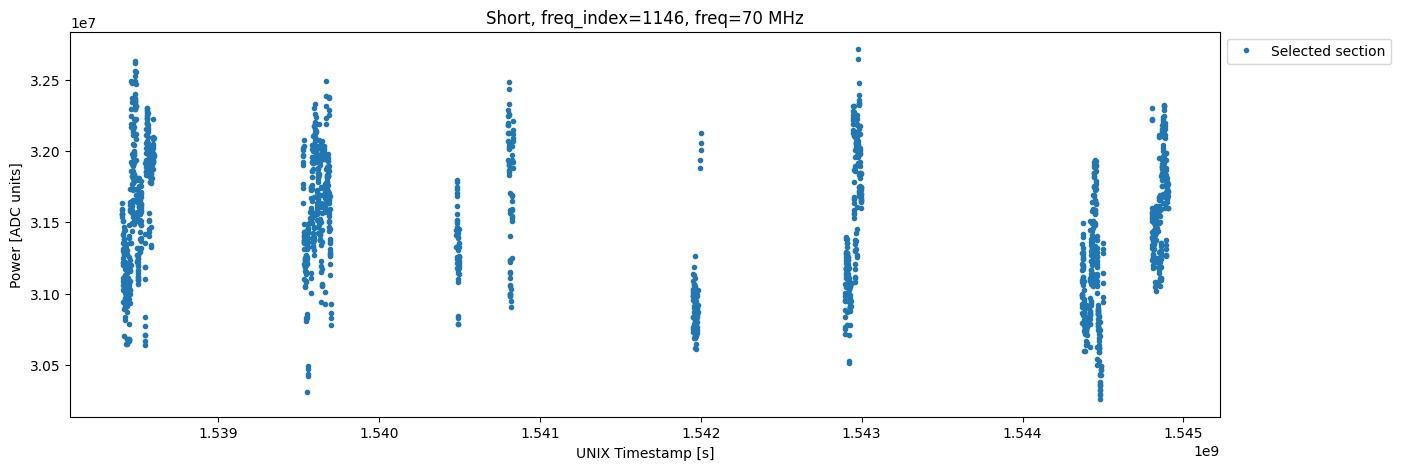

In [159]:
# vs UNIX timestamp

freq = 70 # MHz
freq_index = int(freq/freqstep)

plt.figure(figsize=(20,5))
# plt.plot(t,dat[:,freq_index],'.',label='All times')
plt.plot(tt,dd[:,freq_index],'.',label='Selected section')
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.show()

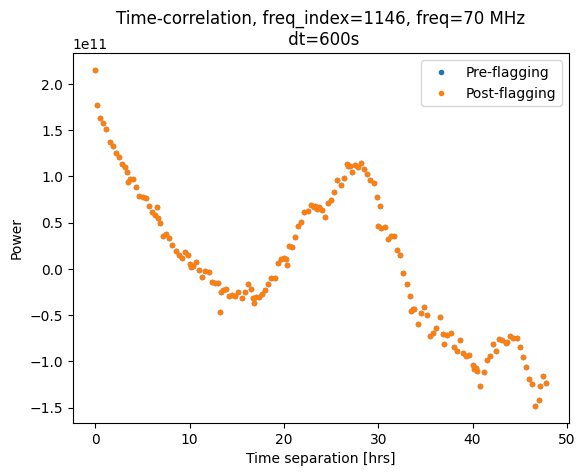

In [157]:
tmax=1.545e9
tmin=1.535e9

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]
ll=lst[mask]

mask_nm=(t_nomask>tmin)&(t_nomask<tmax)
tt_nomask=t_nomask[mask_nm]
dd_nomask=dat_nomask[mask_nm,:]
ll_nomask=lst_nomask[mask_nm]

freq = 70 # MHz
freq_index = int(freq/freqstep)

dt=600
tot,wt=make_acf(dd_nomask[:,freq_index]-dd_nomask[:,freq_index].mean(),tt_nomask,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
mm=wt>30
plt.clf()
plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='Pre-flagging')

tot,wt=make_acf(dd[:,freq_index]-dd[:,freq_index].mean(),tt,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
mm=wt>30

plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'.',label='Post-flagging')

plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.legend()